In [ ]:
!mkdir data
from google.colab import auth
auth.authenticate_user()
!gsutil -m cp -r gs://audio-bucket20200620/ ./data

mkdir: cannot create directory ‘data’: File exists
Copying gs://audio-bucket20200620/bed.zip...
Copying gs://audio-bucket20200620/bird.zip...
Copying gs://audio-bucket20200620/cat.zip...
Copying gs://audio-bucket20200620/dog.zip...
\ [4/4 files][149.1 MiB/149.1 MiB] 100% Done                                    
Operation completed over 4 objects/149.1 MiB.                                    


In [ ]:
!mkdir uncompressed_data
!unzip -q /content/data/audio-bucket20200620/bed.zip -d uncompressed_data
!unzip -q /content/data/audio-bucket20200620/bird.zip -d uncompressed_data
!unzip -q /content/data/audio-bucket20200620/cat.zip -d uncompressed_data
!unzip -q /content/data/audio-bucket20200620/dog.zip -d uncompressed_data

mkdir: cannot create directory ‘uncompressed_data’: File exists


In [ ]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [ ]:
train_audio_path = "uncompressed_data/"

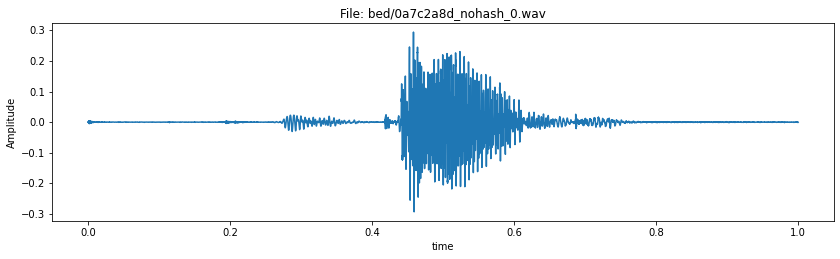

In [ ]:
samples, sample_rate = librosa.load(train_audio_path+'bed/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('File: bed/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [ ]:
ipd.Audio(samples, rate=sample_rate)

In [ ]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [ ]:
labels=os.listdir(train_audio_path)

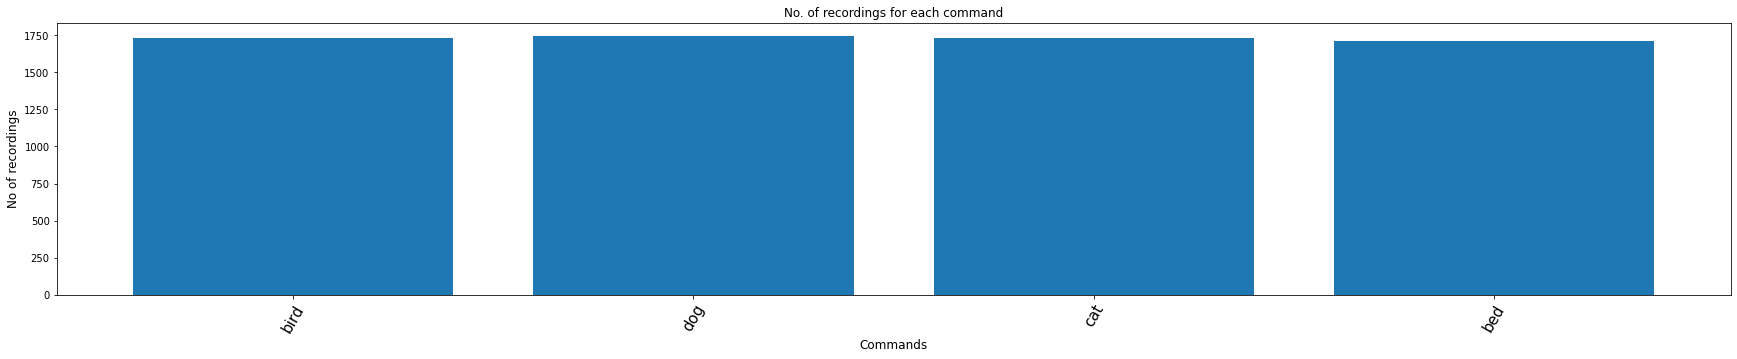

In [ ]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [ ]:
labels = ["bed", "bird", "cat", "dog"]

(array([  14.,   10.,   13.,   20.,   84.,   64.,  152.,  119.,  219.,
        6228.]),
 array([0.4644375 , 0.51799375, 0.57155   , 0.62510625, 0.6786625 ,
        0.73221875, 0.785775  , 0.83933125, 0.8928875 , 0.94644375,
        1.        ]),
 <a list of 10 Patch objects>)

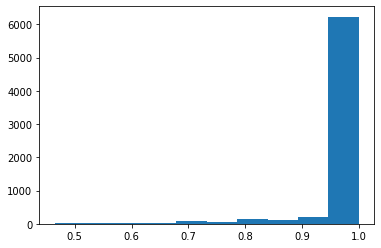

In [ ]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [ ]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

bed
bird
cat
dog


In [ ]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [ ]:
import pickle
output = open('encoder.pkl', 'wb')
pickle.dump(le, output)
output.close()



In [ ]:
!gsutil cp encoder.pkl gs://audio-bucket20200620/

Copying file://encoder.pkl [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/316.0 B.                                      


In [ ]:


from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave), np.array(y), stratify=y, test_size = 0.2, random_state=777, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(np.array(all_wave), np.array(y), stratify=y, test_size = 0.5, random_state=777, shuffle=True)

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(x_tr, y_tr ,epochs=30, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/30
152/152 [==============================] - 2s 10ms/step - loss: 1.3597 - accuracy: 0.3029 - val_loss: 1.1883 - val_accuracy: 0.4550
Epoch 2/30
152/152 [==============================] - 1s 8ms/step - loss: 1.0748 - accuracy: 0.5160 - val_loss: 0.9086 - val_accuracy: 0.6334
Epoch 3/30
152/152 [==============================] - 1s 8ms/step - loss: 0.8547 - accuracy: 0.6485 - val_loss: 0.7222 - val_accuracy: 0.7221
Epoch 4/30
152/152 [==============================] - 1s 8ms/step - loss: 0.7063 - accuracy: 0.7130 - val_loss: 0.7267 - val_accuracy: 0.7036
Epoch 5/30
152/152 [==============================] - 1s 8ms/step - loss: 0.6392 - accuracy: 0.7474 - val_loss: 0.7200 - val_accuracy: 0.7313
Epoch 6/30
152/152 [==============================] - 1s 8ms/step - loss: 0.5796 - accuracy: 0.7799 - val_loss: 0.5185 - val_accuracy: 0.8131
Epoch 7/30
152/152 [==============================] - 1s 8ms/step - loss: 0.4933 - accuracy: 0.8115 - val_loss: 0.5014 - val_accuracy: 0.8266
Epoch

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

95/95 - 0s - loss: 0.1580 - accuracy: 0.9535 - 367ms/epoch - 4ms/step
Restored model, accuracy: 95.35%


In [ ]:
model.save('gs://audio-bucket20200620/model_folder')

INFO:tensorflow:Assets written to: gs://audio-bucket20200620/model_folder/assets


In [ ]:
import tensorflow as tf
model_load = tf.keras.models.load_model('gs://audio-bucket20200620/model_folder')